<h1>Distributed Federated Learning with MNIST Data</h1>

<b>Importing the libraries</b>

<ul>
<li> Pytorch (to train the model)
<li> Pysyft (to train using federated approach)
</ul>

In [1]:
import pickle
import itertools
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import time
import copy
import numpy as np
import syft as sy
from syft.frameworks.torch.fl import utils
import pandas as pd
import itertools
import random
import datetime

In [2]:
class Parser:
     def __init__(self):
        self.batch_size = 64
        self.test_batch_size = 1000
        self.epochs = 15
        self.lr = 0.01
        self.momentum = 0.5
        self.no_cuda = False
        self.seed = 1
        self.log_interval = 30
        self.save_model = False
        self.num_of_workers = 3
    
args = Parser()
torch.manual_seed(args.seed)
kwargs = {'num_workers': 1, 'pin_memory': False}

<b>Download MNIST Data using torchvision datasets module</b>

In [3]:
train_loader = DataLoader( # <-- this is now a FederatedDataLoader 
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    #.federate((bob, alice)), # <-- NEW: we distribute the dataset across all the workers, it's now a FederatedDataset
    batch_size=1, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.test_batch_size, shuffle=True, **kwargs)

<b>Creating architecture of the Neural Network model</b>

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)
        self.previous_accuracy = 0
        self.previous_params = {}

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
    def federated_avg(self, neighbour_model_params=None, current_worker=None):
        #Average two models weights
        
        self.previous_params = {key: value.copy() for key, value in self.state_dict().items()}
        
        params1 = self.state_dict()
        #print(self.previous_params, params1)
        params2 = neighbour_model_params #neighbour_model_params.copy()
      
        with torch.no_grad():
            for name1 in params1:
                if name1 in params2:
                    neighbour_ptr = params2[name1].copy()
                    neighbour_ptr.move(current_worker)
                    #print(current_worker, neighbour_ptr)
                    params1[name1] = (params1[name1]  + neighbour_ptr)/2
        
                    
        self.load_state_dict(params1, strict=False)
        
    def federated_avg_multi(self, neighbour_model_params, current_worker=None):
        
        if len(neighbour_model_params) == 1:
            self.federated_avg(neighbour_model_params[0], current_worker)
        else:
            params1 = self.state_dict()
            for params2 in neighbour_model_params: 
                #params2 = neighbour_model_params #neighbour_model_params.copy()
                with torch.no_grad():
                    for name1 in params1:
                        if name1 in params2:
                            neighbour_ptr = params2[name1].copy()
                            neighbour_ptr.move(current_worker)
                    #print(current_worker, neighbour_ptr)
                            params1[name1] = params1[name1]  + neighbour_ptr
            
            #Averaging model weights
            scale = len(neighbour_model_params) + 1
            with torch.no_grad():
                for name in params1:
                    #print("#######param  ", name)
                    params1[name] = params1[name] / scale
                
            #Load back new params to model        
            self.load_state_dict(params1, strict=False)
        
    def rollback_exchange(self):
        self.load_state_dict(self.previous_params, strict=False)
    

In [5]:
#Create events list for virutal workers exchange of parameters.
def create_events(num_of_workers):
    worker_events = list(itertools.combinations(range(1,num_of_workers+1),2))
    random.shuffle(worker_events)
    
    events_df = pd.DataFrame(worker_events,columns=['worker_id1','worker_id2'])
    events_df.index.names = ["batchnum"]
    return events_df

In [6]:
events_df = create_events(args.num_of_workers)
events_df

,worker_id1,worker_id2
batchnum,,
0,1,2
1,2,3
2,1,3


<b>Initilizer Function to create Virtual workers, initiate models and optimizers. Data will split amongst workers and trained.</b>

In [7]:
def initialize_workers():
    hook = sy.TorchHook(torch)
    compute_nodes = [sy.VirtualWorker(hook, id=f"worker-{i}") for i in range(args.num_of_workers)]
    remote_dataset = tuple(list() for _ in range(args.num_of_workers))
    input_worker_dataset = [list() for _ in range(args.num_of_workers)]
    target_worker_dataset = [list() for _ in range(args.num_of_workers)]
    target_counter = {}
    ##target_worker_split = {0:0, 1:1, 2:(2,0), 3:1, 4:0, 5:1, 6:2, 7:1, 8:(2,0), 9:2 }  ##target values for 3 workers
    #target_worker_split = {0:0, 1:1, 2:0, 3:1, 4:(1,0), 5:(1,0), 6:(0,1), 7:1, 8:(0,1), 9:0 }    ##target values for 2 workers
    target_worker_split = {0:0, 1:1, 2:2, 3:0, 4:2, 5:1, 6:2, 7:0, 8:1, 9:2 }
    
    for batch_idx, (data,target) in enumerate(train_loader):
        target_value = target.item()
        
        if isinstance(target_worker_split[target_value], tuple):
            current_worker_idx = target_worker_split[target_value][0]
            target_worker_split[target_value] = tuple(reversed(target_worker_split[target_value]))
        else:
            current_worker_idx = target_worker_split[target.item()]
        
        if len(target_worker_dataset[current_worker_idx]) == args.batch_size:
            input_data , target_values = list(zip(*target_worker_dataset[current_worker_idx]))
            target_values = torch.cat(target_values)
            input_data = torch.cat(input_data)
            remote_data = input_data.send(compute_nodes[current_worker_idx])
            remote_target = target_values.send(compute_nodes[current_worker_idx])
            remote_dataset[current_worker_idx].append((remote_data, remote_target))
            target_worker_dataset[current_worker_idx] = list()
            
        
        target_worker_dataset[current_worker_idx].append((data, target))
            
        
    models = [Net() for _ in range(args.num_of_workers)]
    optimizers = [optim.SGD(models[i].parameters(), lr=args.lr) for i in range(args.num_of_workers)]
    return compute_nodes, remote_dataset, models, optimizers


In [8]:
def update(data, target, model, optimizer):
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    return model

In [9]:
def exchange_parameters(models, data_index):
    #Get the workers ID from event dataframe to exchange parameters between two worker models.
    event_idx = data_index % len(events_df)
    event_row = events_df.loc[[event_idx]]
    worker_id1 = event_row['worker_id1'].values[0]-1
    worker_id2 = event_row['worker_id2'].values[0]-1
    worker1_model = models[worker_id1]
    worker2_model = models[worker_id2]
    worker1_params = worker1_model.state_dict()
    worker2_params = worker2_model.state_dict()
    
    #Send worker2 params to worker1 for averaging at worker1
    worker1_model.federated_avg(worker2_params, compute_nodes[worker_id1])
    #print(worker1_model)
    worker1_model.get()
    #model_copy = worker1_model.copy()
    #model_copy.get()
    #print(model_copy)
    _, current_accuracy = test(worker1_model, compute_nodes[worker_id1])
    worker1_model = worker1_model.send(compute_nodes[worker_id1])
    models[worker_id1] = worker1_model
    #print("#########Node - {}  accuracy after exchange  - {} accuracy in last epoch - {}".format(compute_nodes[worker_id1], current_accuracy, worker1_model.previous_accuracy ))
    
    if current_accuracy < worker1_model.previous_accuracy:
        worker1_model.rollback_exchange()
    else:
        worker1_model.previous_accuracy = current_accuracy
        
    
    #Send worker1 params to worker2 for averaging at worker2
    worker2_model.federated_avg(worker1_params, compute_nodes[worker_id2])
    #model_copy = worker2_model.copy()
    worker2_model.get()
    _, current_accuracy = test(worker2_model, compute_nodes[worker_id2])
    worker2_model = worker2_model.send(compute_nodes[worker_id2])
    models[worker_id2] = worker2_model
    #print("###########Node - {}  accuracy after exchange  - {} accuracy in last epoch - {}".format(compute_nodes[worker_id2], current_accuracy, worker2_model.previous_accuracy ))
    if current_accuracy < worker2_model.previous_accuracy:
        worker2_model.rollback_exchange()
    else:
        worker2_model.previous_accuracy = current_accuracy

def exchange_parameters_multiple(models, data_index=None):
    #Get the workers ID from event dataframe to exchange parameters between two worker models.
    #current_worker_idx = data_index % len(compute_nodes)
    #worker1_model = models[current_worker_idx]
    #worker1_params = worker1_model.state_dict().copy()
    worker_params = [model.state_dict().copy() for model in models]
    idx = 0
    
    for node in compute_nodes:
        other_worker_params = [param for i, param in enumerate(worker_params) if i != idx ]
        models[idx].federated_avg_multi(other_worker_params, compute_nodes[idx])
        idx += 1
    
        
    
    ##Copy the model to other workers
    #new_models = [] #[worker1_model.copy().move(node) for i, node in enumerate(compute_nodes) if i != current_worker_idx]
    #for i, node in enumerate(compute_nodes):
    #    if i == current_worker_idx:
    #        print("###CURRENT######", type(worker1_model), node, worker1_model)
    #        new_models.append(worker1_model)
    #    else:
    #        neighbour_model_ptr = worker1_model.copy()
    #        print("###other######", type(neighbour_model_ptr), node, worker1_model.location, neighbour_model_ptr)
    #        neighbour_model_ptr.move(node)
    #        new_models.append(neighbour_model_ptr)
    #        print("###After mive######", type(neighbour_model_ptr), node, neighbour_model_ptr)
    
    #return new_models
    
   

In [16]:
def train(models, compute_nodes, remote_dataset, optimizers, epoch_id, federated_average=False, exchange=False):
    
    if federated_average:
        models = [models.copy() for _ in range(args.num_of_workers)]
        optimizers = [optim.SGD(models[i].parameters(), lr=args.lr) for i in range(args.num_of_workers)]
        
    models = [model.send(compute_nodes[i]) for i, model in enumerate(models)]
    

    
    for remote_index in range(len(compute_nodes)):
        #print(f"Trip {data_index} and length of remote_dataset in {len(remote_dataset[0])} {len(remote_dataset[1])} {len(remote_dataset[2])}")
        for data_index in range(len(remote_dataset[remote_index])):
            data, target = remote_dataset[remote_index][data_index]
            models[remote_index] = update(data, target, models[remote_index], optimizers[remote_index])
        
    
       #Exchange of parameter between two remote models.
    if exchange:
        exchange_parameters(models, epoch_id)
        #exchange_parameters_multiple(models, epoch_id)
        
        
    for model in models:
        model.get()
        
    
    #if exchange:
    #    return models
        
    #Federated Average
    if federated_average:
        model =  utils.federated_avg({f"worker-{i}":models[i] for i in range(len(compute_nodes))})
        return model

In [11]:
def test(federated_model, worker_id):
    federated_model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = federated_model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            prediction = output.argmax(1, keepdim=True)
            correct += prediction.eq(target.view_as(prediction)).sum().item()
           
        
    test_loss /= len(test_loader.dataset)
    avg_correct = correct / len(test_loader.dataset)
    #print('Test set for worker {}: Average loss: {:.4f} & Average Accuracy : {:.4f}'.format(worker_id, test_loss, avg_correct))
    return test_loss, avg_correct
    

In [12]:
def run_epochs(models, compute_nodes, remote_dataset, optimizers, federated_average=False, exchange=False):
    model = Net()
    
    eval_results = []
    for epoch in range(args.epochs):
        start_time = time.time()
        print(f"Epoch Number {epoch + 1}")
        

        if exchange:
            #models = train(models, compute_nodes, remote_dataset, optimizers, epoch, federated_average, exchange)
            train(models, compute_nodes, remote_dataset, optimizers, epoch, federated_average, exchange)
            for worker_node, worker_model in zip(compute_nodes, models):
                avg_loss, avg_accuracy = test(worker_model, worker_node.id)
                print('Test set for worker {}: Average loss: {:.4f} & Average Accuracy : {:.4f}'.format(worker_node.id, avg_loss, avg_accuracy))
                results = {"worker_id" : worker_node.id,
                          "epoch_idx" : epoch,
                          "avg_loss": avg_loss,
                          "avg_accuracy" : avg_accuracy}
                eval_results.append(results)
        elif federated_average:
            
            federated_model = train(model, compute_nodes, remote_dataset, optimizers, epoch, federated_average, exchange)
            avg_loss, avg_accuracy = test(federated_model, "federated_avg_local")
            print('Test set for worker {}: Average loss: {:.4f} & Average Accuracy : {:.4f}'.format("federated_avg_local", avg_loss, avg_accuracy))
            results = {"worker_id" : "federated_avg_local",
                          "epoch_idx" : epoch,
                          "avg_loss": avg_loss,
                          "avg_accuracy" : avg_accuracy}
            eval_results.append(results)
            model = federated_model
        else:
            train(models, compute_nodes, remote_dataset, optimizers, epoch, federated_average, exchange)
            for worker_node, worker_model in zip(compute_nodes, models):
                avg_loss, avg_accuracy = test(worker_model, worker_node.id)
                print('Test set for worker {}: Average loss: {:.4f} & Average Accuracy : {:.4f}'.format(worker_node.id, avg_loss, avg_accuracy))
                results = {"worker_id" : worker_node.id,
                          "epoch_idx" : epoch,
                          "avg_loss": avg_loss,
                          "avg_accuracy" : avg_accuracy}
                eval_results.append(results)
            
        total_time = time.time() - start_time
        print('Communication time over the network', round(total_time, 2), 's\n')
    return eval_results

###  Simulation with training on individual workers on their local data

In [13]:
start_time = time.time()
print(f"Start time {datetime.datetime.now()}")
compute_nodes, remote_dataset, models, optimizers = initialize_workers()
individual_train_results = run_epochs(models, compute_nodes, remote_dataset, optimizers, federated_average=False, exchange=False)
print(f"Total time taken for simulation -1 is {time.time() - start_time}")
print(f"End time {datetime.datetime.now()}")    
    

Start time 2021-03-06 10:06:26.839915
Epoch Number 1
Test set for worker worker-0: Average loss: 8.0698 & Average Accuracy : 0.2969
Test set for worker worker-1: Average loss: 8.5712 & Average Accuracy : 0.2907
Test set for worker worker-2: Average loss: 6.4508 & Average Accuracy : 0.3825
Communication time over the network 82.86 s

Epoch Number 2
Test set for worker worker-0: Average loss: 8.5670 & Average Accuracy : 0.2984
Test set for worker worker-1: Average loss: 9.2313 & Average Accuracy : 0.2940
Test set for worker worker-2: Average loss: 6.5208 & Average Accuracy : 0.3871
Communication time over the network 82.95 s

Epoch Number 3
Test set for worker worker-0: Average loss: 8.7468 & Average Accuracy : 0.2988
Test set for worker worker-1: Average loss: 9.4259 & Average Accuracy : 0.2948
Test set for worker worker-2: Average loss: 6.5030 & Average Accuracy : 0.3900
Communication time over the network 81.11 s

Epoch Number 4
Test set for worker worker-0: Average loss: 8.8464 & Ave

###  Simulation with training  with federated average

In [14]:
start_time = time.time()
print(f"Start time {datetime.datetime.now()}")
compute_nodes, remote_dataset, models, optimizers = initialize_workers()
fedavg_train_results = run_epochs(models, compute_nodes, remote_dataset, optimizers, federated_average=True, exchange=False)
print(f"Total time taken for simulation -1 is {time.time() - start_time}")
print(f"End time {datetime.datetime.now()}")    
    

Start time 2021-03-06 10:27:21.192787
Epoch Number 1
Test set for worker federated_avg_local: Average loss: 1.6066 & Average Accuracy : 0.5538
Communication time over the network 72.48 s

Epoch Number 2
Test set for worker federated_avg_local: Average loss: 0.9080 & Average Accuracy : 0.8030
Communication time over the network 72.34 s

Epoch Number 3
Test set for worker federated_avg_local: Average loss: 0.6026 & Average Accuracy : 0.8520
Communication time over the network 71.96 s

Epoch Number 4
Test set for worker federated_avg_local: Average loss: 0.4644 & Average Accuracy : 0.8765
Communication time over the network 73.23 s

Epoch Number 5
Test set for worker federated_avg_local: Average loss: 0.3845 & Average Accuracy : 0.8952
Communication time over the network 72.41 s

Epoch Number 6
Test set for worker federated_avg_local: Average loss: 0.3313 & Average Accuracy : 0.9060
Communication time over the network 72.04 s

Epoch Number 7
Test set for worker federated_avg_local: Averag

###  Simulation with training  with Decentralized federated average

In [17]:
start_time = time.time()
print(f"Start time {datetime.datetime.now()}")
compute_nodes, remote_dataset, models, optimizers = initialize_workers()
decentrailized_fedavg_train_results = run_epochs(models, compute_nodes, remote_dataset, optimizers, federated_average=False, exchange=True)
print(f"Total time taken for simulation -1 is {time.time() - start_time}")
print(f"End time {datetime.datetime.now()}")  

Start time 2021-03-06 10:51:26.963681
Epoch Number 1
Test set for worker worker-0: Average loss: 2.2991 & Average Accuracy : 0.2919
Test set for worker worker-1: Average loss: 3.3767 & Average Accuracy : 0.2909
Test set for worker worker-2: Average loss: 6.0121 & Average Accuracy : 0.3819
Communication time over the network 92.25 s

Epoch Number 2
Test set for worker worker-0: Average loss: 7.4249 & Average Accuracy : 0.2963
Test set for worker worker-1: Average loss: 2.1724 & Average Accuracy : 0.3999
Test set for worker worker-2: Average loss: 2.7707 & Average Accuracy : 0.3863
Communication time over the network 88.94 s

Epoch Number 3
Test set for worker worker-0: Average loss: 2.0351 & Average Accuracy : 0.3536
Test set for worker worker-1: Average loss: 8.2743 & Average Accuracy : 0.2924
Test set for worker worker-2: Average loss: 2.6587 & Average Accuracy : 0.3868
Communication time over the network 87.55 s

Epoch Number 4
Test set for worker worker-0: Average loss: 6.8596 & Ave

In [18]:
ind_train_df = pd.DataFrame(individual_train_results)
ind_train_df

,worker_id,epoch_idx,avg_loss,avg_accuracy
0,worker-0,0,8.069844,0.2969
1,worker-1,0,8.571244,0.2907
2,worker-2,0,6.450829,0.3825
3,worker-0,1,8.567019,0.2984
4,worker-1,1,9.231328,0.2940
5,worker-2,1,6.520847,0.3871
6,worker-0,2,8.746754,0.2988
7,worker-1,2,9.425901,0.2948
8,worker-2,2,6.502990,0.3900
9,worker-0,3,8.846434,0.2993


In [19]:
fedavg_train_df = pd.DataFrame(fedavg_train_results)
fedavg_train_df

,worker_id,epoch_idx,avg_loss,avg_accuracy
0,federated_avg_local,0,1.606586,0.5538
1,federated_avg_local,1,0.908008,0.8030
2,federated_avg_local,2,0.602646,0.8520
3,federated_avg_local,3,0.464395,0.8765
4,federated_avg_local,4,0.384477,0.8952
5,federated_avg_local,5,0.331336,0.9060
6,federated_avg_local,6,0.293537,0.9164
7,federated_avg_local,7,0.264675,0.9248
8,federated_avg_local,8,0.242261,0.9301
9,federated_avg_local,9,0.223894,0.9363


In [20]:
decentrailized_fedavg_train_df = pd.DataFrame(decentrailized_fedavg_train_results)
decentrailized_fedavg_train_df

,worker_id,epoch_idx,avg_loss,avg_accuracy
0,worker-0,0,2.299111,0.2919
1,worker-1,0,3.376715,0.2909
2,worker-2,0,6.012086,0.3819
3,worker-0,1,7.424871,0.2963
4,worker-1,1,2.172395,0.3999
5,worker-2,1,2.770673,0.3863
6,worker-0,2,2.035087,0.3536
7,worker-1,2,8.274319,0.2924
8,worker-2,2,2.658668,0.3868
9,worker-0,3,6.859576,0.2972


### Plot Graph for Individual worker training accuracy over time.

In [21]:
#%matplotlib inline
#for key, grp in ind_train_df.groupby(['worker_id']):
#    grp.plot(x="epoch_idx", y="avg_accuracy", label=key, ylabel="avg_accuracy")



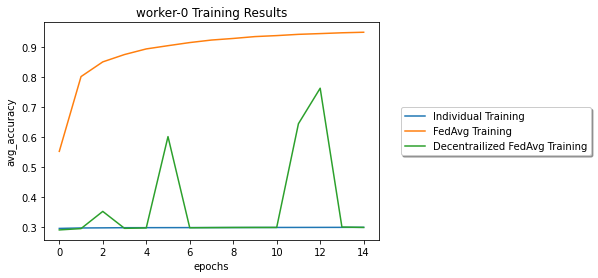

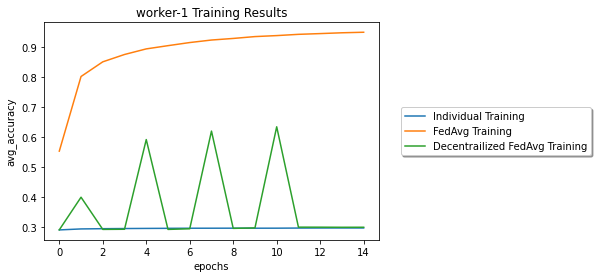

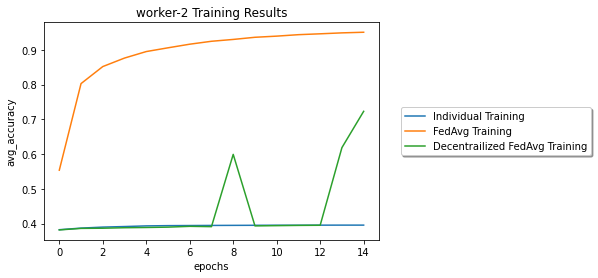

In [22]:
%matplotlib inline
ind_train_df
fedavg_train_df
decentrailized_fedavg_train_df
for node in compute_nodes:
    ind_worker_data  = ind_train_df[ind_train_df['worker_id']==node.id]
    plt.plot(ind_worker_data['epoch_idx'],ind_worker_data['avg_accuracy'], label="Individual Training")

    plt.plot(fedavg_train_df['epoch_idx'],fedavg_train_df['avg_accuracy'], label="FedAvg Training")
    
    decentral_worker_data  = decentrailized_fedavg_train_df[decentrailized_fedavg_train_df['worker_id']==node.id]
    plt.plot(decentral_worker_data['epoch_idx'],decentral_worker_data['avg_accuracy'], label="Decentrailized FedAvg Training")
    
    plt.xlabel('epochs')
    # Set the y axis label of the current axis.
    plt.ylabel('avg_accuracy')
    # Set a title of the current axes.
    plt.title(f'{node.id} Training Results')
    # show a legend on the plot
    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), shadow=True)
    # Display a figure.
    plt.show()